# Creating a Delft3D FM 1D2D fluvial flood model of Magdalena river 

The exercises in this notebook will serve as introduction on how to use [HYDROLIB-core](https://github.com/Deltares/HYDROLIB-core) functionalities. We will create and adjust a Delft3D FM Suite 1D2D fluvial flood model of the Magdalena river in Columbia. 

First a 1D river model of the Magdalena river and Canal del Dique will be created, shown in the left figure. This model will be extended with a 2D Flexible Mesh, with a uniform roughness field. Adding a Digital Terrain Model (DTM) on that 2D mesh is currently not part of this tutorial, but in practice this is indispensible to mimic the fluvial flood patterns.

<p align="center">
  <img alt="1D2D" src="figures/1D2D_model.png" width="45%">
</p>

Note that the model that will be created is for educational purposes and consists partially of fictive or unvalidated model data. 

## Using HYDROLIB-core to build models
HYDROLIB-core is a Python package that offers functionality to process D-HYDRO input files. It offers Python-wrapped classes that represent these files and their content. 
HYDROLIB-core serves as the basis for various pre- and postprocessing tools for a modelling workflow of hydrodynamic simulations in D-HYDRO. It can easily be used to build models and export the model files that can aftewards be run by dflowfm or other supported D-HYDRO kernels.

## Content of the tutorial

The goal of this tutorial is to familiarize modelers with applying HYDROLIB-core functionalities in their modelling procedures for building new models or adjusting existing models. As mentioned above, you will create an 1D2D fluvial flood model from scratch using the D-Flow FM HYDROLIB-core functionalities and the underlying functions from mesh generation ([MeshKernelPy](https://github.com/Deltares/MeshKernelPy)). We will walk through the following steps to build the model:

1. Selecting the data location
2. Creating an empty D-Flow FM model
3. Reading the branch data from a shape file
4. Creating and assigning a 1D computational grid to the model
5. Adding cross-sections to the branches
6. Adding cross-section definitions
7. Adding roughness to the model
8. Adding boundary conditions to the model
9. Adding initial water depths
10. Adding a weir to a branch
11. Finishing up and saving the model
12. Creating a 2D flexible mesh
13. Refining the 2D grid locally
14. Saving the 1D2D model

## 💡 Tips for working in the Jupyter Notebook
  * __Tab__: Auto-complete on code
  * __Shift__+__Tab__: Tooltip
  * __Ctrl__+__Enter__: Run cell 
  * __Shift__+__Enter__: Run cell and move to next cell 
  * __Ctrl__+__Shift__+__P__: Open command palette

## Import the needed modules
Several Python packages are required to run the notebook. These packages are imported below. Please consult the [HYDROLIB-core documentation](https://deltares.github.io/HYDROLIB-core/0.5.2/) if you want to use additional HYDROLIB-core functionalities later.

In [188]:
# General
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

# MeshKernel
import meshkernel as mk
from meshkernel import GeometryList, MakeGridParameters

# HYDROLIB-core
from hydrolib.core.dflowfm.mdu import FMModel, AutoStartOption
from hydrolib.core.dflowfm.net.models import *
from hydrolib.core.dflowfm.crosssection.models import CrossLocModel, CrossDefModel, YZCrsDef
from hydrolib.core.dflowfm.friction.models import *
from hydrolib.core.dflowfm.bc.models import *
from hydrolib.core.dflowfm.ext.models import *
from hydrolib.core.dflowfm.inifield.models import *
from hydrolib.core.dflowfm.onedfield.models import *
from hydrolib.core.dflowfm.structure.models import Weir, FlowDirection, StructureModel

print("Imports were successful!")


Imports were successful!


## Here starts the tutorial

### 1. Selecting the data location

**Exercise** 🧩: Create a variable that contains the Path to the ```data``` folder.

In [189]:
root = Path.cwd()
data_dir = root / 'data'

print(f"Data location: {data_dir}")

Data location: c:\checkouts\HYDROLIB\HYDROLIB-core\HYDROLIB-core_3\docs\tutorials\dsd_2023\magdalena_workflow\data


### 2. Creating an empty D-Flow FM model

To start a model from scratch, you first need to create an empty model without data. In this tutorial we will create a D-Flow FM model. The MDU file (master definition file) is the main input file of the D-Flow FM model.

A new D-Flow FM model is constructed with the `FMModel` initializer. 

**Exercise** 🧩
* Create a variable containing a new `FMModel` object.
* Create a variable containing the export directory 
* Export the D-Flow FM model to an MDU file inside the export directory

API references: 
* [FMModel](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/mdu/#hydrolib.core.dflowfm.mdu.models.FMModel)
* [FileModel.filepath](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/api/#hydrolib.core.basemodel.FileLoadContext.retrieve_model)
* [FileModel.save()](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/api/#hydrolib.core.basemodel.FileModel.save)

In [190]:
model = FMModel()
export_dir = root / 'export'
model.filepath = export_dir / 'Magdalena_1D.mdu'
model.save()

print(f"Model saved: {model.filepath}")

Model saved: c:\checkouts\HYDROLIB\HYDROLIB-core\HYDROLIB-core_3\docs\tutorials\dsd_2023\magdalena_workflow\export\Magdalena_1D.mdu


## Part 1: Setting up a 1D Delft3D FM model
In this part we will build up the complete 1D model schematization step by step. At the end you should have a complete set of model input files for a 1D calculation.

### 3. Reading the branch data from a shape file
The model will include the lower part of the Magadalena from Cordoba Teton to the river mouth Baranquilla and the Canal del Dique.

**Exercise 🧩**
* Read the branch data from the `branches_Branches.shp` file
* Print the branch data, such that we can answer the following questions:
  * How many river branches does the model have?
  * What are their names?
  * Which friction type and friction value is used for each branch?

API references: 
* [gpd.read_file](https://geopandas.org/en/stable/docs/reference/api/geopandas.read_file.html#geopandas-read-file)

In [191]:
# Read the branches
branch_shp_file = data_dir / 'branches_Branches.shp'
branches_gdf = gpd.read_file(filename = branch_shp_file)

print(branches_gdf)

# Answers:
# * 3 branches
# * Channel_1D_1_A, Channel_1D_1_B and Channel_1D_1
# * Channel_1D_1_A: Manning, 0.03 
#   Channel_1D_1_B: Manning, 0.02
#   Channel_1D_1  : Manning, 0.02 

             Name  BridgeCount  CrossSectio  CulvertCoun  GateCount  \
0  Channel_1D_1_A            0            0            0          0   
1  Channel_1D_1_B            0            0            0          0   
2    Channel_1D_1            0            0            0          0   

     GeometryLen IsLengthCus  LateralSour         Length LongName  \
0   99845.093077           F            0  101023.779052     None   
1  111429.230469           F            0  113923.354861     None   
2  117327.933796           F            0  116641.023471     None   

   OrderNumber  PumpCount   Source  StructureCo   Target  WeirCount fric_type  \
0           -1          0  Node001            0  Node003          0   Manning   
1           -1          0  Node003            0  Node002          0   Manning   
2           -1          0  Node003            0  Node005          0   Manning   

   fric_value  chainage                                           geometry  
0        0.03    1000.0  LINESTRING 

### 4. Creating and assigning a 1D computational grid to the model

In the previous step we read the geometry and attributes of the branches from the shape file. This branch data will become the network input for our D-Flow FM model. 

Since the model does not have a network yet, we need to create a new `Network` object and assign it to the model. A network may contain a 1D network, a 2D mesh and 1D2D links.

**Exercise 🧩**
* Create a new network
* Assign the network to the model and assign a (relative) file path for the net file
* The new network should contain the data that we read from the shape file:
  * Three `Branch` objects will need to be added to the network. 
  * For each branch, the name, geometry and computational grid points should be provided. 
  * The computational points are not included in the data, we will need to generate those with a grid point distance as specified:

    | **Branch name** | **dx [m]** |
    |-----------------|------------|
    | Channel_1D_1_A  | 1000       |
    | Channel_1D_1_B  | 1000       |
    | Channel_1D_1    | 500        |

Hint 💡: The MDU file contains a [Geometry] section which has the `NetFile` reference, e.g.:

```
[Geometry]
netFile                    = FlowFM_net.nc
bathymetryFile             =
dryPointsFile              =
structureFile              = structures.ini
iniFieldFile               = initialFields.ini
...
```

API references: 
* [Network](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/net/#hydrolib.core.dflowfm.net.models.Network)
* [NetworkModel](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/net/#hydrolib.core.dflowfm.net.models.NetworkModel)
* [Branch](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/net/#hydrolib.core.dflowfm.net.models.Branch)
* [Branch.generate_nodes()](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/net/#hydrolib.core.dflowfm.net.models.Branch.generate_nodes)
* [Network.mesh1d_add_branch()](TODO)

In [192]:
# Assign a new network to the D-Flow FM model and specify the file path
network = Network()
model.geometry.netfile.network = network
model.geometry.netfile.filepath = "FlowFM_net.nc"

# Specify 1D computational grid point distance per branch
dx_per_branch = {
    "Channel_1D_1_A" : 1000,
    "Channel_1D_1_B" : 1000,
    "Channel_1D_1" : 500,
}

# Assign geometry of the branches and generate the computational grid on top of the branches.
for index, branch_data in branches_gdf.iterrows():
    xy = np.transpose(branch_data.geometry.xy)    
    branch_new = Branch(geometry=xy) 
    branch_new.generate_nodes(mesh1d_edge_length=dx_per_branch[branch_data.Name])
    network.mesh1d_add_branch(branch_new, name=branch_data.Name)

network._mesh1d._set_mesh1d()

We can plot the branches onto a background:

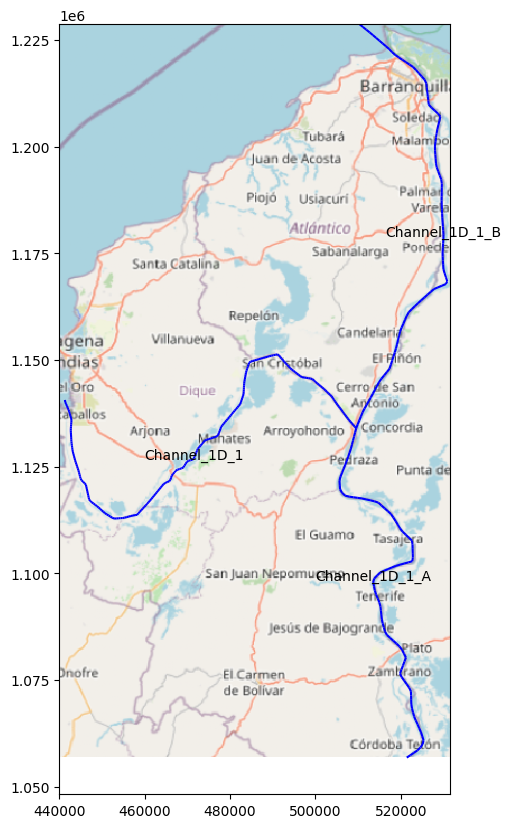

In [193]:
# Create a figure with the 1D network
figure, axis = plt.subplots(ncols=1)
img = plt.imread(data_dir / "osm_background.png")

# Add branch names to the plot
for branch_name, branch in network._mesh1d.branches.items():
    middle = int((len(branch.geometry) - 1)/2)
    xy = branch.geometry[middle]
    axis.text(xy[0], xy[1], branch_name, ha='center')

axis.imshow(img, extent=[440000,
                        531544.97964175534434617,
                        1057000,
                        1228644.01383191486820579])

network._mesh1d._get_mesh1d().plot_edges(ax=axis, color='blue')

### 5. Adding cross-sections to the branches

In order to determine the flow area of the 1D model during the computation, you need cross-sections. These cross-sections are defined by two components: 
1. Cross-section locations
2. Cross-section definitions

The cross-section locations and cross-section definitions are exported to their own file.

A **cross-section location** is defined by the following information:
* The cross-section ID
* A location, specified by a branch ID and a chainage.
* A shift, the vertical shift of the cross section profile. This is mainly used to create a good longitudinal slope over the 1D model (in case of shared cross-sections).
* A reference to the cross-section definition that is used at this location.

<p align="center">
<img alt="Light" src="figures/crosloc.png" width="80%" >
<p\>

A **cross-section definition** is defined by the following information:
* The cross-section definition ID
* The cross-section type: circle, rectangle, ZW river, ZW, YZ, XYZ
* Depending on the type of cross-section, a set of properties describing the properties of the profile shape

<p align="center">
<img alt="Light" src="figures/crsdef.png" width="40%" >
<p\>

In our data folder, there is a CSV file containing the cross-section locations. We want to convert this data to HYDROLIB-core cross-section location objects and add them to the D-Flow FM model. The columns in the CSV correspond exactly with the field names of a `CrossSection` class, making the conversion easy.

**Exercise 🧩**
* Read the data from the CSV file
* Print the cross-section location data, to answer the following questions:
  * How many cross-section does the model contain in total, and how many does each branch have?
  * Do the cross-section have shared cross-section definitions? A shared cross-section definition is a definition used by more than one cross-section.
* Convert the CSV data (a pd.DataFrame) into a HYDROLIB-core `CrossSection`
* Assign a file path to the cross section location file
* Assign the cross section locations to the model

Hint 💡: The MDU file contains a [Geometry] section which has the `crossDefFile` and `crossLocFile` reference, e.g.:

```
[Geometry]
crossDefFile = crsdef.ini
crossLocFile = crsloc.ini
...
```

API references: 
* [CrossLocModel](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/crosssection/#hydrolib.core.dflowfm.crosssection.models.CrossLocModel)
* [CrossSection](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/crosssection/#hydrolib.core.dflowfm.crosssection.models.CrossSection)
* [pd.read_csv()](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html#pandas-read-csv)
* [pd.to_dict()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html#pandas-dataframe-to-dict)

In [194]:
cross_section_location_file = data_dir / 'cross_section_locations.csv'
cross_section_locations_df = pd.read_csv(cross_section_location_file, index_col=False)

print(cross_section_locations_df)
# Answers:
# * There are 6 cross-sections in the model and each branch has two cross-sections 
# * There are no shared cross-section definitions; each cross-section has a unique definition ID.

cross_loc_model = CrossLocModel()
cross_loc_model.filepath = 'crsloc.ini'

cross_loc_model.crosssection = cross_section_locations_df.to_dict("records")
model.geometry.crosslocfile = cross_loc_model

              id        branchId  chainage  shift       definitionId
0  CrossSection1  Channel_1D_1_A      1000      0  CrossSection_1D_1
1  CrossSection2  Channel_1D_1_A     95000      0  CrossSection_1D_2
2  CrossSection3  Channel_1D_1_B      1000      0  CrossSection_1D_3
3  CrossSection4  Channel_1D_1_B     95000      0  CrossSection_1D_4
4  CrossSection5    Channel_1D_1      1000      0  CrossSection_1D_5
5  CrossSection6    Channel_1D_1    113000      0  CrossSection_1D_6


### 6. Adding cross-section definitions

In the following exercise we will add the cross-section definitions to the D-Flow FM model. These belong to the cross-section we added in the previous step. These cross-sections all have YZ-profiles in order to define a natural shape of the river. 


Please finish the code below.

**Exercise 🧩**
* Create a new cross-section definition model with the defined properties
* Create an YZ profile for each profile from the excel file
* Append each YZ profile to the cross-section definition model
* Make sure the data is assigned to the D-Flow FM model

API references: 
* [CrossDefModel](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/crosssection/#hydrolib.core.dflowfm.crosssection.models.CrossDefModel)
* [YZCrsDef](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/crosssection/#hydrolib.core.dflowfm.crosssection.models.YZCrsDef)


In [195]:
profiles_file = data_dir / '1D_YZ_CrossSections.xlsx'
profile_excel_data = pd.read_excel(profiles_file, sheet_name=None)
profile_names = list(profile_excel_data)
print(profile_names)

cross_def_model = CrossDefModel()
cross_def_model.filepath = 'crsdef.ini'

# Properties for each YZ profile
type_crs = 'yz'
thalweg = 0.0
single_valued_z = 'yes'
conveyance = 'segmented'
sectionCount = 1
friction_ids = 'channels'

# Create the YZ profiles and append them to the CrossDefModel
for profile_name in profile_names:
    profile_data = profile_excel_data[profile_name]
    num_coords = len(profile_data.values)
    y_coords = profile_data.y.to_list()
    z_coords = profile_data.z.to_list()

    friction_positions = [profile_data.y[0], profile_data.y[num_coords-1]]

    # Create an YZ profile
    cross_section = YZCrsDef(id=profile_name, 
        type=type_crs, 
        thalweg=thalweg, 
        singleValuedZ=single_valued_z, 
        conveyance=conveyance,
        yzCount=num_coords, 
        yCoordinates=y_coords, 
        zCoordinates = z_coords,
        sectionCount = sectionCount,
        frictionIds = friction_ids,
        frictionPositions=friction_positions)
    
    cross_def_model.definition.append(cross_section)

model.geometry.crossdeffile = cross_def_model


['CrossSection_1D_1', 'CrossSection_1D_2', 'CrossSection_1D_3', 'CrossSection_1D_4', 'CrossSection_1D_5', 'CrossSection_1D_6']


### 7. Adding roughness to the model

Our 1D D-Flow FM model now has a network topology, computational grid points and cross-sections. 
Friction is a component that should be added to the model to get the proper bed roughness and channel conveyance.

For each branch, we will add a friction type and value at the upstream location.
We will also specify a global roughness section. This will be used when there is no friction defined for a branch. It also contains a friction ID. In the cross-section definitions we created above, a reference is made to this friction ID (='channels').

YZ profiles can refer to multiple friction IDs, since the friction can vary within the cross-section. This also means that multiple friction definition files can be added to one D-Flow FM model.

In [196]:
channel_friction_id = 'channels'
channel_global_type = FrictionType.manning
channel_global_value = 0.023

channel_friction_model = FrictionModel()
channel_friction_model.filepath = "roughness-channels.ini" # It is conventional to specify the file names as "roughness-[friction ID].ini"

# Create global friction model and add it to frictionmodel
channel_global_friction = FrictGlobal(frictionId=channel_friction_id,
                              frictionType=channel_global_type,
                              frictionValue=channel_global_value)
channel_friction_model.global_ = channel_global_friction

function_type = 'constant'

# Create friction definition per branch
for index, branch_data in branches_gdf.iterrows():
    
    friction_per_branch = FrictBranch(branchId=branch_data.Name,
                                      frictionType=branch_data.fric_type,
                                      frictionValues=[branch_data.fric_value],
                                      chainage=[branch_data.chainage],
                                      numLocations=1,
                                      functionType=function_type)
    
    channel_friction_model.branch.append(friction_per_branch)
    
model.geometry.frictfile = [channel_friction_model]

We want to defined another global friction definition for the Canal del Dique. This friction model assumes Chezy as global friction type and a friction value of 45.

**Exercise 🧩** 
* Create a new friction model for Canal del Dique
* Specify a global friction definition
* Make sure the new friction model is added to the D-Flow FM model

API references: 
* [FrictionType](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/friction/#hydrolib.core.dflowfm.friction.models.FrictionType)
* [FrictionModel](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/friction/#hydrolib.core.dflowfm.friction.models.FrictionModel)
* [FrictGlobal](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/friction/#hydrolib.core.dflowfm.friction.models.FrictGlobal)

In [197]:

dique_friction_id = 'dique'
dique_global_type = FrictionType.chezy
dique_global_value = 45.0

dique_friction_model = FrictionModel()
dique_friction_model.filepath = 'roughness-dique.ini'

dique_global_friction = FrictGlobal(frictionId=dique_friction_id,
                              frictionType=dique_global_type,
                              frictionValue=dique_global_value)
dique_friction_model.global_ = dique_global_friction

model.geometry.frictfile.append(dique_friction_model)

The cross-sections on the Canal del Dique (Channel_1D_1) do not refer to this new friction ID yet.

**Exercise 🧩** 
* Use the cross-section locations and definitions in the D-Flow FM model to find the cross-sections on the Channel_1D_1 branch
* Reassign the friction ID of the correct cross sections to one used for the Canal del Dique

In [198]:
cross_section_definitions = model.geometry.crossdeffile.definition
cross_section_locations = model.geometry.crosslocfile.crosssection

# Create a dictionary with the definition IDs, for easily finding the correct definition
definition_dict = {definition.id: definition for definition in cross_section_definitions} 

for cross_section in cross_section_locations:
    if cross_section.branchid == "Channel_1D_1":
        cross_section_definition = definition_dict[cross_section.definitionid]
        cross_section_definition.frictionids = [dique_friction_id]

### 8. Adding boundary conditions to the model
Fluvial floods occur when water levels in the river are too high. These high water levels in the rivers can result from several factors. One of those is the occurence of heavy rainfall in the upstream catchment. These heavy rainstorms can lead to a high discharge wave entering the upstream boundary of the river. 

In order to apply boundary conditions on a model you need data from two files:
* **External forcing file (*.ext)**: specifies the location and type of forcing.
* **Boundary conditions file (*.bc)**: contains the forcing values, e.g. a time series or a constant value

In this tutorial you will model such a high discharge wave (time series) at the upstream 1D boundary. For the two downstream boundaries a constant water level of 0 m AD is assumed. Note that this are tidal boundaries in reality. 

**Exercise 🧩** 
* Complete the code below by adding the boundary locations to the external forcing model. 
* For each boundary location (3), the correct boundary object should be created with a quantity, node ID and forcing file. The quantity keys for discharge and water level are 'dischargebnd' and 'waterlevelbnd', respectively.

API references: 
* [Boundary](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/ext/#hydrolib.core.dflowfm.ext.models.Boundary)

In [199]:
ext_model = ExtModel()    # External forcing file (.ext)
bc_model = ForcingModel() # Boundary conditions file (.bc)
model.external_forcing.extforcefilenew = ext_model

# Read the upstream boundary time series from excel 
discharge_file = data_dir / '1D_BoundaryConditions.xlsx'
discharge_excel_df = pd.read_excel(discharge_file, sheet_name=[0])

node_ids = model.geometry.netfile.network._mesh1d.network1d_node_id 
print(node_ids)

node_upstream    = node_ids[0]    # time series discharge node
nodes_downstream = node_ids[2:]   # constant water level nodes

# Create the discharge timeseries
bc_upstream = TimeSeries(
    name = node_upstream,
    nodeid = node_upstream,
    timeinterpolation = TimeInterpolation.linear,
    quantityunitpair = [QuantityUnitPair(quantity = 'time', unit = 'minutes since 2012-01-01 00:00:00'), QuantityUnitPair(quantity = 'dischargebnd', unit = 'm³/s')],
    datablock = [[time, dis] for [time,dis] in discharge_excel_df[0].values])
bc_model.forcing.append(bc_upstream)

# Create the constant water level
for node_downstream in nodes_downstream:
    bc_downstream = Constant(
        name = node_downstream,
        nodeid = node_downstream,
        quantityunitpair = [QuantityUnitPair(quantity = 'waterlevelbnd', unit = 'm')],
        datablock = [["0.0"]])
    
    bc_model.forcing.append(bc_downstream)

# Create the boundary locations for the discharge and the water level
ext_upstream = Boundary(
    quantity = 'dischargebnd',
    nodeid = node_upstream,
    forcingfile = bc_model)
ext_model.boundary.append(ext_upstream)

for node_downstream in nodes_downstream:
    ext_downstream = Boundary(
        quantity = 'waterlevelbnd',
        nodeid = node_downstream,
        forcingfile = bc_model
    )
    ext_model.boundary.append(ext_downstream)


['521410.278872_1056811.761107' '509553.389407_1133991.497936'
 '510370.485693_1228630.596516' '441306.810437_1140614.443396']


### 9. Adding initial water depths
For this model an initial water depth of 1.0 meter is assumed in the 1D model. 

Below we add an initial water depth to the model with the following steps:
1. Creating global 1D initial conditions field, containing an initial water depth of 1.0. Note that it is also possible to define the initial water depth per branch.
2. Creating an initial field file containing the initial water depth data for our 1D network

In [200]:
# Create 1D initial conditions field file
ini_1d = OneDFieldModel()
ini_1d.global_ = OneDFieldGlobal(quantity='waterdepth', unit='m', value=1.0)
ini_1d.filepath = 'initialwaterdepth.ini'
ini_1d.save(export_dir / ini_1d.filepath) # 1D field ini files needs to be saved seperately, because it is not completely supported yet)

# Create initial field file
ini_field_model = IniFieldModel()
ini_field_model.filepath = 'inifield.ini'
ini_field_model.initial = InitialField(quantity='waterdepth',datafile=ini_1d.filepath, datafiletype=DataFileType.onedfield)

# Assign data to the model
model.geometry.inifieldfile = ini_field_model

### 10. Adding a weir to a branch
Many lakes occur close along Canal del Dique. See figure below. This tutorial assumes that these lakes can function as extra storage for the floods from the river. Hence a weir structure, functioning as a small dam, is added downstream of the lakes. This weir structure has the following conditions:
* It is located at 70 km from the upstream node of the branch (Channel_1D_1). 
* The crest level is 4.0 m AD.
* The crest width is 105.0 m. 
* The flow over the dam is in both directions. 

<p align="center">
<img alt="Light" src="figures/multiple_lakes.png" width="40%" >
<p\>

**Exercise 🧩** 
* Create a new weir object with the described properties
* Create a new structure model and add the new weir to it
* Assign the data to the D-Flow FM model

In [201]:
# Create weir structure
weir = Weir(
    id='fictive_dam', 
    name = 'fictive_dam',
    branchId='Channel_1D_1', 
    chainage=70000.0, 
    allowedFlowDir=FlowDirection.both, 
    crestLevel=4.0, 
    crestWidth=105.0, 
    corrCoeff=1.000, 
    useVelocityHeight=True
)

# Create structure model
structure_model = StructureModel()
structure_model.filepath = 'structure.ini'

# Append weir to structure
structure_model.structure.append(weir)

# Assign structure model to D-Flow FM model
model.geometry.structurefile = [structure_model]

After creating the weir, you want to adjust some values. You found out that the dam should be significantly higher.

**Exercise 🧩** 
* Increase the crest level to 10.0
* Change the flow direction to positive (from upstream to downstream)

In [202]:

weir.crestlevel = 10.0
weir.allowedflowdir = FlowDirection.positive

### 11. Finishing up and saving the model

The 1D model is almost finished now. We first change some time settings and then save the model.


**Exercise 🧩** 
* Export the full model to the export folder

API references: 
* [FileModel.save()](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/api/#hydrolib.core.basemodel.FileModel.save)


In [203]:
# Change some time settings
model.time.refdate = '20120101'
model.time.dtuser = 60. # seconds
model.time.tstart = 43200.
model.time.tstop = 561600.

# Save the model
model.save(recurse=True)

## Part 2: Extending the 1D model to a 1D2D model
We will now continue with the 1D model and add a 2D mesh to it.
We won't add 1D2D coupling, but in practice they should be added to create a true 1D2D model.

### 12. Creating a 2D flexible mesh

Here, we demonstrate how to create a 2D mesh using `MeshKernel`.
Note that the network and mesh functionality in HYDROLIB-core is still in development. 

We use a shape file with the area of interest to define the extent of the new 2D mesh that is to be generated.
First, a uniform rectilinear mesh with a grid cell size of 2500x2500m is generated.
Second, we clip the generated mesh.

API references:
* [Mesh2d](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/net/#hydrolib.core.dflowfm.net.models.Mesh2d) 
* [Mesh2d.clip()](https://deltares.github.io/HYDROLIB-core/0.5.2/reference/net/#hydrolib.core.dflowfm.net.models.Mesh2d.clip)
* [mk.MakeGridParameters](https://deltares.github.io/MeshKernelPy/api/meshkernel.py_structures.html#meshkernel.py_structures.MakeGridParameters)



In [204]:
# Read grid outline
gdf_grid = gpd.read_file(data_dir / 'outline_2D_grid.shp')

# Determine the boundary box
xmin, ymin, xmax, ymax = gdf_grid.geometry[0].bounds

mesh2d = Mesh2d()
mesh_kernel = mesh2d.meshkernel

# Define the grid generation parameters
dx=2500.0
dy=2500.0
num_rows = int((ymax - ymin) / dy)
num_columns = int((xmax - xmin) / dx)
origin_x = xmin
origin_y = ymin
block_size_x = dx
block_size_y = dy

make_grid_parameters = MakeGridParameters()
make_grid_parameters.num_columns = num_columns
make_grid_parameters.num_rows = num_rows
make_grid_parameters.origin_x = origin_x
make_grid_parameters.origin_y = origin_y
make_grid_parameters.block_size_x = dx
make_grid_parameters.block_size_y = dy
make_grid_parameters.upper_right_x = xmax
make_grid_parameters.upper_right_y = ymax

# Create uniform rectilinear mesh
mesh_kernel.curvilinear_make_uniform(make_grid_parameters)
mesh_kernel.curvilinear_convert_to_mesh2d()
mesh2d._process(mesh2d.get_mesh2d())

# Clip resulting mesh within polygon area of interest
# Prepare a clipping polygon for MeshKernel input:
clip_polygon = np.array(gdf_grid.geometry[0].exterior.xy)
clip_geometry_list = GeometryList(clip_polygon[0],clip_polygon[1])
mesh2d.clip(clip_geometry_list)

model.geometry.netfile.network._mesh2d = mesh2d
model.geometry.netfile.filepath = "FlowFM_1D2D_net.nc"


The cell below produces a basic plot of the 1D2D network.

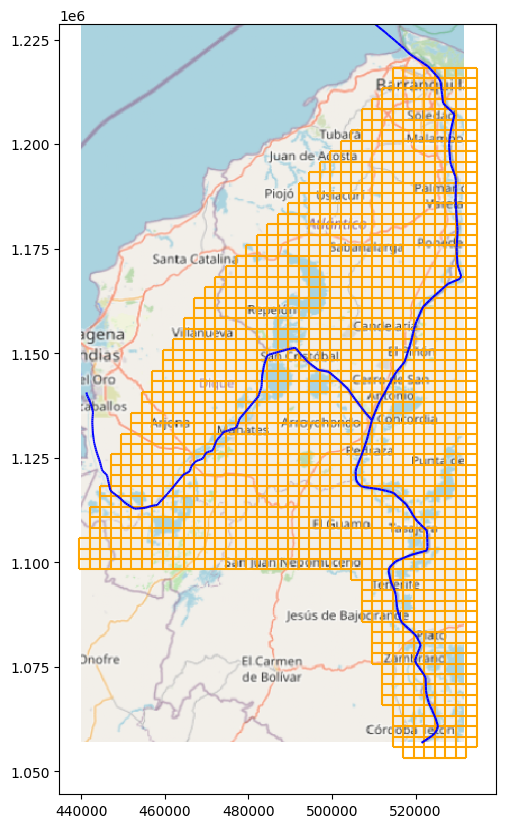

In [205]:
# Create a plot
mesh2d_mk = network._mesh2d.get_mesh2d()
mesh1d_mk = network._mesh1d._get_mesh1d()

figure, axis = plt.subplots()

axis.imshow(img, extent=[440000,
                         531544.97964175534434617,
                         1057000,
                         1228644.01383191486820579])

mesh2d_mk.plot_edges(ax=axis, color="orange")
mesh1d_mk.plot_edges(ax=axis, color='blue')

### 13. Refining the 2D grid locally
Here, we want to refine the 2D mesh around the river using MeshKernel functionality.
We will do one refinement iteration.

**Exercise 🧩** 
* Refine the 2D mesh using MeshKernel with the provided refinment parameters (see code below)

API references: 
* [mk.MeshRefinementParameters](https://deltares.github.io/MeshKernelPy/api/meshkernel.py_structures.html#meshkernel.py_structures.MeshRefinementParameters)
* `mk.mesh2d_refine_based_on_polygon()` (not documented yet):
  * First argument is a `GeometryList` containing the polygon geometry of the area to refine
  * Second argument is a `MeshRefinementParameters` containing all the parameters for refining

In [206]:
# Get the refinement polygon to refine around the river
gdf_refine = gpd.read_file(data_dir / 'buffer_around_river_proj.shp')
refine_polygon = np.array(gdf_refine.geometry[0].exterior.xy)
refine_geom = GeometryList(refine_polygon[0], refine_polygon[1])

# Set parameters
refine_intersected = True
use_mass_center_when_refining = False
min_edge_size = 10.0
refinement_type = 1
connect_hanging_nodes = True
account_for_samples_outside_face = False
max_refinement_iterations = 1

# Refine the 2D mesh
parameters = mk.MeshRefinementParameters(
    refine_intersected=refine_intersected,
    use_mass_center_when_refining=use_mass_center_when_refining,
    min_edge_size=min_edge_size,
    refinement_type=refinement_type,
    connect_hanging_nodes=connect_hanging_nodes,
    account_for_samples_outside_face=account_for_samples_outside_face,
    max_refinement_iterations=max_refinement_iterations,
)

mesh_kernel.mesh2d_refine_based_on_polygon(refine_geom, parameters)

# Set 2D mesh on model
mesh2d._process(mesh2d.get_mesh2d())
model.geometry.netfile.network._mesh2d = mesh2d
model.geometry.netfile.filepath = "FlowFM_1D2D_refined_net.nc"

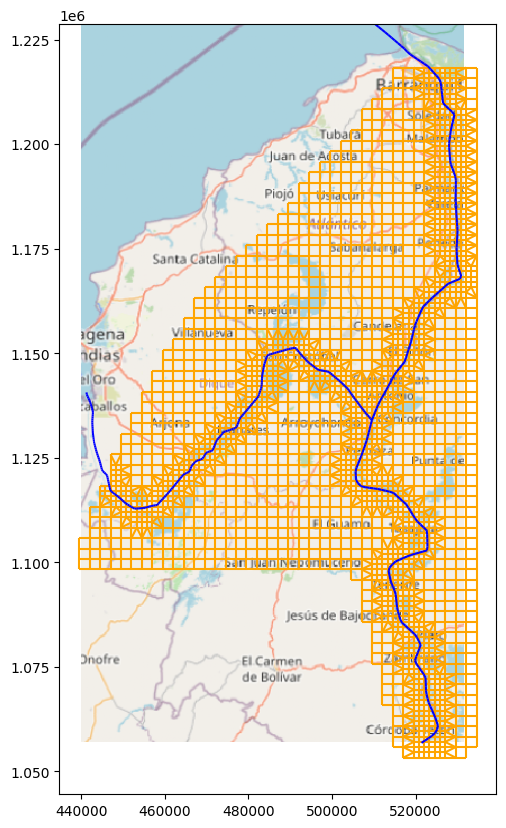

In [207]:
# Create a plot
mesh2d_mk = network._mesh2d.get_mesh2d()
mesh1d_mk = network._mesh1d._get_mesh1d()

figure, axis = plt.subplots()

axis.imshow(img, extent=[440000,
                         531544.97964175534434617,
                         1057000,
                         1228644.01383191486820579])

mesh2d_mk.plot_edges(ax=axis, color="orange")
mesh1d_mk.plot_edges(ax=axis, color='blue')

## 14. Saving the 1D2D model
The 1D2D model is now finished.

**Exercise 🧩** 
* Save the model wherever you like
* Import the D-Flow FM model in the Delft3D FM Suite 1D2D


In [208]:
model.save(recurse=True)